# A/B Testing for Blog Post Engagement Time

While my blog has grown exponentially in monthly sessions and views, my blog's engagement time has remained steady around the 1 minute mark for the last 2 years. Engagement time is a measurement of how much time a user spends on my blog.

I want to increase time spent on my blog. 

I recently wrote an 3-day itinerary for Busan. From online research, one of the ways I can increase engagement time is by including a Table of Contents for my longer posts. 

I used a power analysis to determine the sample size. With a statistical power of 80%, significance of 10%, and effect of 0.5. I would need at least 120 participants. Plus, each participant would need to be interested in traveling to Busan or else it wouldn't make sense for them to read the blog. I personally don't know 120 people who would be interested in going to Busan so I tried to ask as many people as I could. 

I asked roughly 70 people to engage in this study. I split the sample size into two groups - one group got the blog post with a table of contents and the other group got one without. The following code was used to randomly generate the two groups and then analyze the time results.

In [1]:
# import required libraries

import pandas as pd
import numpy as np
from scipy import stats
import random 

import seaborn as sns 
import matplotlib.pyplot as plt 

### Split the sample into two groups using random

Randomly place participants into 2 groups. 
Since there is personal information on the excel file, I will not include the file when uploading this to github. 

In [2]:
sample_data = pd.read_excel('sample_info.xlsx')

### prep the pandas df ###

# drop the participant number column in python for easier data manipulation
sample_data = sample_data.drop(columns='Participant_Number')

# set the index column to start at 1
sample_data.index += 1

### create two groups at random for the A/B test from the pandas sample_data df ###

# to make this reproducible, add a random seed from numpy
np.random.seed(0)

# Create 2 groups:
# Group A = no table of contents. so regular post style. set group A = 0
# Group B = with table of contents. new post style. set group B = 1

# determine the group size from the list of people
group_size = int(len(sample_data) / 2)

# assign each person to group A or group B
assignments = np.array([0]*group_size + [1]*group_size) # concatenate the two groups together
np.random.shuffle(assignments)

# Add the assignments to dataframe
sample_data['group'] = assignments

# make a sep. column for who is in which group 
sample_data['group_details'] = sample_data['group'].map({0:'groupA_noTOC',1:'groupB_TOC'})

# print out string format of people in each group to send in email
# string format will be email1; email2; email3;...

groupA = sample_data[sample_data['group']==0]['Email']
groupA_list_str = ';'.join(map(str,groupA))

groupB = sample_data[sample_data['group']==1]['Email']
groupB_list_str = ';'.join(map(str,groupB))

### One sided T-Test

In [3]:
sample_data_results_df = pd.read_excel('sample_data_results.xlsx')

print(sample_data_results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  67 non-null     object 
 1   group                 67 non-null     object 
 2   group_details         67 non-null     object 
 3   Read_times (minutes)  51 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.2+ KB
None


As you can tell, I didn't get everybody's response back. Let's remove all the empty rows. 

In [4]:
sample_data_results_df = sample_data_results_df.dropna(axis=0)

print(sample_data_results_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 0 to 66
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  51 non-null     object 
 1   group                 51 non-null     object 
 2   group_details         51 non-null     object 
 3   Read_times (minutes)  51 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.0+ KB
None


Let's plot the distribution of read times for each group.

Group A will be the control group. The control group won't have a table of contents.
Group B will have the table of contents. 

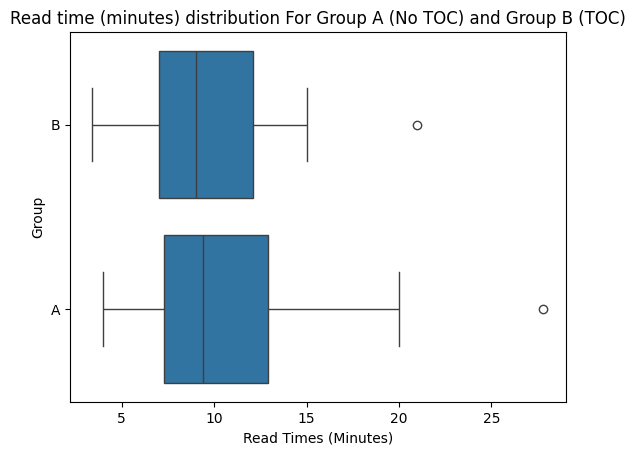

In [13]:
sns.boxplot(data=sample_data_results_df, x='Read_times (minutes)', y='group', orient='h')
plt.title('Read time (minutes) distribution For Group A (No TOC) and Group B (TOC)')
plt.xlabel('Read Times (Minutes)')
plt.ylabel('Group')
plt.show()

Both group A and group B have similar median read times, suggesting that the typical read time is comparable between the two groups. 

The interquartile ranges (boxes) have similar widths, meaning that the variability in the central tendency is about the same for both groups.

Both also have outliers with group A having a larger outlier. 

Group A also has a larger spread of read times as shown by the longer whiskers. 

Since Group A has a larger spread and larger outliers, this suggests that there are some unusually longer readers in group A. 

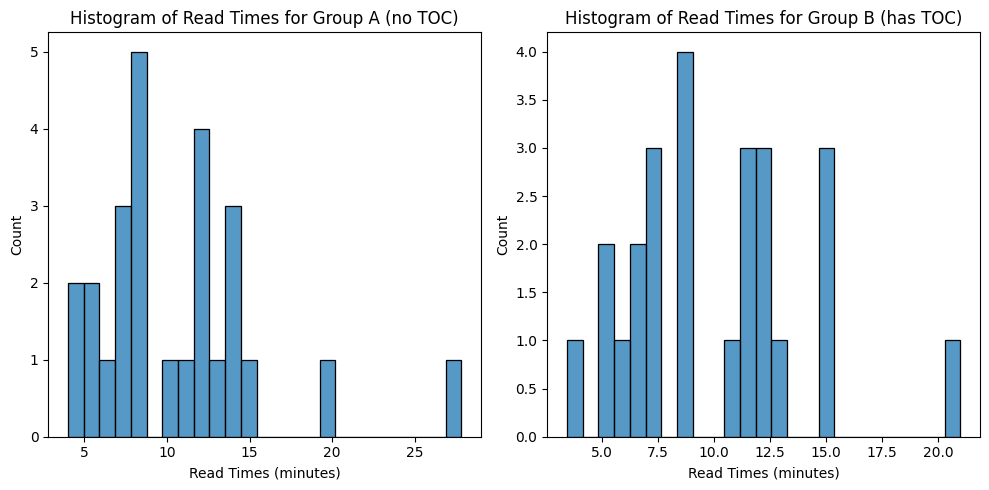

In [24]:
# lets plot the histograms 

groupA = sample_data_results_df[sample_data_results_df['group']=='A']
groupB = sample_data_results_df[sample_data_results_df['group']=='B']

fig, axes = plt.subplots(1,2,figsize=(10,5))

sns.histplot(data=groupA, x='Read_times (minutes)', bins=25, ax=axes[0])
axes[0].set_title('Histogram of Read Times for Group A (no TOC)')
axes[0].set_xlabel('Read Times (minutes)')

sns.histplot(data=groupB, x='Read_times (minutes)', bins=25, ax=axes[1])
axes[1].set_title('Histogram of Read Times for Group B (has TOC)')
axes[1].set_xlabel('Read Times (minutes)')

plt.tight_layout()
plt.show()

There are 2 readers in group A that spent more than 20 minutes on the blog while there's only 1 in group B. Since there are more outliers in group A, group A shows a slight right skew in the data while group B looks a bit more symmetrical and closer to a normal distribution 

Both graphs suggest that most of the readers spent between 7-10 minutes on the blog post. 

Since I am running a t-test, I am assuming that the data is roughly normally distributed. Outliers can make the distribution non-normal. Some of the outliers in each group are slow readers (they told me when they responded back to me with their read times). Now in real life, I won't know my subjects, but since their reading skills don't have anything to do with the table of contents, I will remove their read times from the sample.

Since there are no outliers on the lower side of the distribution, we will just look at those who have read times > Q3 + 1.5 * Q1

In [26]:
q1_groupA = np.percentile(groupA['Read_times (minutes)'], 25)
q3_groupA = np.percentile(groupA['Read_times (minutes)'], 75)
IQR_A = q3_groupA - q1_groupA
upper_boundA = q3_groupA + 1.5*IQR_A
print("upper bound times for group A readers is: ", upper_boundA)

q1_groupB = np.percentile(groupB['Read_times (minutes)'], 25)
q3_groupB = np.percentile(groupB['Read_times (minutes)'], 75)
IQR_B = q3_groupB - q1_groupB
upper_boundB = q3_groupB + 1.5*IQR_B
print("upper bound times for group B readers is: ", upper_boundB)


upper bound times for group A readers is:  21.322916666666664
upper bound times for group B readers is:  19.708333333333336


In [28]:
# remove the outliers from each group

groupA = groupA[groupA['Read_times (minutes)'] <= upper_boundA]
groupB = groupB[groupB['Read_times (minutes)'] <= upper_boundB]

In [33]:
# print out the mean read time and standard deviations for each group

print("Group A stats: \n")
print(groupA['Read_times (minutes)'].describe())
print("")
print("Group B stats: \n")
print(groupB['Read_times (minutes)'].describe())

Group A stats: 

count    25.000000
mean      9.892167
std       3.839716
min       4.000000
25%       7.233333
50%       8.750000
75%      12.566667
max      20.000000
Name: Read_times (minutes), dtype: float64

Group B stats: 

count    24.000000
mean      9.523396
std       3.379409
min       3.416667
25%       6.958333
50%       8.830750
75%      11.933333
max      15.000000
Name: Read_times (minutes), dtype: float64


Run the one sided t-test

I'm testing if Group B (readers with a TOC) has a higher mean than Group A (without a TOC)
My alpha level = 0.10. I would typically set my alpha to 0.05 since that's been the standard value I set for most of my problems. I set it slightly higher because I don't need my average read time to be much greater than what it is currently. This work is for exploratory purposes rather than for making long term blog style changes. If I am 90% confident that it does increase the read time, then that's good enough. 

Null hypothesis: u_B <= u_A
alternative hypothesis: u_B > u_A

In [30]:
t_stat, p_two_sided = stats.ttest_ind(groupB['Read_times (minutes)'], groupA['Read_times (minutes)'], equal_var=False) 
# equal_var = False means Welch's test since the variance between the two groups are not equal. 

if t_stat > 0:
    # we can do a one side t-test 
    p_one_sided = p_two_sided / 2
    print("One sided p-value (uB > uA): ", p_one_sided)
else:
    print(" t value is: ", t_stat)
    print(" T value is negative - uB is not greater than uA")
    p_one_sided = 1

alpha = 0.10

if p_one_sided < alpha:
    print("Our test results is statistically significant. We can reject the null hypothesis. There is enough evidence to suggest that having a table of contents increases reader engagement time.")
else:
    print("The p-value is > alpha. We cannot reject the null hypothesis.")



 t value is:  -0.3572416642113376
 T value is negative - uB is not greater than uA
The p-value is > alpha. We cannot reject the null hypothesis.


### Final Thoughts & Conclusion

The T value is negative, which means the mean read time for those who had a table of contents was less than the mean read time for those who didn't have it. 

I went back and asked if people used the table of contents - nobody used it, which was a little surprising. 

I would need to grab more samples to see if my results change; however, in the mean time, the current A/B test and people's feedback suggest that a table of contents won't change reader engagement time. It won't hurt to include one, but I shouldn't expect a noticeable change in reader engagement time. 